In [1]:
import backtrader as bt
import quantstats
import akshare as ak
import efinance as ef
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import run
import sys
import math
import imgkit
from PIL import Image
from scipy import stats
import empyrical as ey
import itertools 
import collections
import datetime
import riskfolio as rp

### 1，找出所有需要的基金代码

In [125]:
mix_fund = pd.read_excel('每季度四只基金（终）.xlsx',sheet_name = '混合型基金')
stock_fund = pd.read_excel('每季度四只基金（终）.xlsx',sheet_name = '股票型基金')

In [126]:
list1 = mix_fund.基金代码.unique().tolist()
list2 = stock_fund.基金代码.unique().tolist()
list1.extend(list2)

In [127]:
##去除nan
list1 =  [a for a in list1 if a == a]
##去除后缀便于取数
list1 = [i[:6] for i in list1]

In [128]:
print(list1)

['400015', '162201', '519095', '320007', '377240', '375010', '519005', '162202', '240022', '110025', '398041', '519110', '020023', '290012', '540008', '163818', '206012', '159906', '671010', '540010', '121002', '162102', '162411', '163208', '160416', '320022', '159909', '159918', '159915']


### 2，利用akshare取基金日频净值数据

In [152]:
def get_data(code, start_date = "20000101", end_date = "20220331"):
    def download_data(code):
        try:
            data = ak.fund_open_fund_info_em(code)
        except KeyError as e:
            print(e)
        print(data.columns)
        data.净值日期 = pd.to_datetime(data.净值日期)
        data.set_index("净值日期", drop = False, inplace = True)
        return data
            
    stockfile = "./datas/"+code+".csv"
    if os.path.exists(stockfile) :
        stock_data = pd.read_csv(stockfile)
        stock_data['净值日期'] = pd.to_datetime(stock_data['净值日期'])
        stock_data.set_index("净值日期", drop = False, inplace = True)
        # stock_data = stock_data.loc[start_date:datetime.datetime(end_date) + datetime.timedelta(days = 1), :]
        end_date = datetime.datetime.strptime(end_date, "%Y%m%d") + datetime.timedelta(days = 1)
        stock_data = stock_data.loc[start_date:end_date, :]
        stock_data = stock_data.drop(['净值日期','日增长率','净值日期.1'],axis = 1)
    else:
        stock_data = download_data(code)
        if os.path.exists(stockfile):
            os.system("rm " + stockfile)
        stock_data.to_csv(stockfile)
        stock_data = stock_data.drop(['净值日期','日增长率'],axis = 1)
    list1 = []
    list1.append(code)
    stock_data.columns = list1
    return stock_data

In [153]:
#制作数据宽表便于批量操作
df1 = get_data(list1[0])
for i in range(1,len(list1)):
    df2 =  get_data(list1[i])
    df1 = pd.merge(left = df1,right = df2,left_on = df1.index,right_on= df2.index).set_index('key_0')

In [154]:
df1

,400015,162201,519095,320007,377240,375010,519005,162202,240022,110025,...,540010,121002,162102,162411,163208,160416,320022,159909,159918,159915
key_0,,,,,,,,,,,,,,,,,,,,,
2012-12-10,0.9649,0.9109,1.1190,0.785,1.0500,1.6361,0.4970,0.7874,0.982,0.837,...,0.8526,0.7956,0.6594,0.9410,0.952,0.994,1.000,2.2140,0.8275,0.6495
2012-12-14,0.9882,0.9227,1.1450,0.789,1.0690,1.6848,0.5120,0.8033,0.994,0.856,...,0.8751,0.8126,0.6729,0.9380,0.948,0.994,1.000,2.2540,0.8411,0.6592
2012-12-21,0.9929,0.9233,1.1530,0.783,1.0550,1.6920,0.5080,0.8013,1.005,0.875,...,0.8708,0.8080,0.6756,0.9620,0.961,1.009,1.000,2.2870,0.8518,0.6709
2012-12-28,1.0326,0.9528,1.2230,0.815,1.1150,1.7741,0.5350,0.8313,1.017,0.901,...,0.9132,0.8433,0.6935,0.9250,0.939,0.991,1.001,2.3690,0.8972,0.7101
2012-12-31,1.0455,0.9560,1.2600,0.828,1.1240,1.8130,0.5430,0.8405,1.024,0.912,...,0.9228,0.8532,0.7034,0.9460,0.952,1.002,1.002,2.3860,0.9034,0.7160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,3.6071,2.0312,4.1755,1.707,6.4728,1.6519,1.2411,3.3385,3.457,1.471,...,2.7823,1.8978,1.3351,0.5325,0.821,1.231,2.249,0.6949,2.0126,2.6466
2022-02-15,3.7523,2.1409,4.3092,1.775,6.6504,1.7004,1.2875,3.4498,3.463,1.487,...,2.8899,1.9090,1.3403,0.5265,0.813,1.222,2.298,0.7130,2.0464,2.7282
2022-02-16,3.7560,2.1436,4.3171,1.769,6.6339,1.6934,1.2924,3.4583,3.474,1.493,...,2.8582,1.9152,1.3458,0.5234,0.814,1.231,2.311,0.7100,2.0513,2.7300


### 3，编写函数批量计算risk parity权重与min risk 权重

In [155]:
def calculate_weight(codelist,startdate ='2017-01-01',enddate = '2017-03-31',objdf = obj):
    obj = objdf[startdate:enddate][codelist]
    Y = obj.pct_change().dropna()
    port = rp.Portfolio(returns=Y)
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
    w_rp = port.rp_optimization(model='Classic', rm='MV', rf=0, b=None, hist=True)
    w_mr = port.optimization(model='Classic', rm='MV', obj='MinRisk', kelly=False, rf=0, l=2, hist=True)
    w_rp.columns = ['w_rp']
    w_mr.columns = ['w_mr']
    df = pd.merge(w_mr,w_rp,left_on=w_mr.index,right_on = w_rp.index).set_index('key_0')
    return df

In [156]:
calculate_weight(['400015','162201','519095','320007'],startdate ='2017-01-01',enddate = '2017-03-31',objdf = df1)

,w_mr,w_rp
key_0,,
400015,4.366972e-01,0.284259
162201,2.993170e-08,0.207013
519095,5.633026e-01,0.280243
320007,1.564849e-07,0.228485


### 4 从结果文档中搜索数据，生成所需数据宽表

In [160]:
def str2timegap(str1 ='2019年第一季度'):
    year = str1[:4]
    if '一' in str1:
        start_md ='01-01'
        end_md ='03-31'
    if '二' in str1:
        start_md ='04-01'
        end_md ='06-30'
    if '三' in str1:
        start_md ='07-01'
        end_md ='09-30'
    if '四' in str1:
        start_md ='10-01'
        end_md ='12-31'
    startdt = year+'-'+ start_md
    enddt = year+'-'+ end_md
    return [startdt,enddt]

In [162]:
def format2result(codelist,str2 = '2019年第一季度'):
    list1=  str2timegap(str2)
    df = calculate_weight(codelist,startdate =list1[0],enddate = list1[1],objdf = df1)
    df['持仓时间'] = str2
    return df

In [172]:
mix_fund['持仓时间'] = mix_fund['持仓时间'].fillna(method = 'ffill')
df_mix = mix_fund[['持仓时间', '基金代码']].dropna(axis = 0)
dict_mix = {}
for i in df_mix['持仓时间'].unique():
    dict_mix[i] = df_mix.loc[df_mix['持仓时间'] == i]['基金代码'].values.tolist()

In [173]:
df_result1 = pd.DataFrame()
for a,b in enumerate(dict_mix):
    listb = [i[:6] for i in dict_mix[b]]
    df = format2result(listb,str2 = b)
    df_result1 =pd.concat([df_result1,df],axis = 0)

In [185]:
stock_fund['持仓时间'] = stock_fund['持仓时间'].fillna(method = 'ffill')
df_stock = stock_fund[['持仓时间', '基金代码']].dropna(axis = 0)
dict_stock = {}
for i in df_stock['持仓时间'].unique():
    dict_stock[i] = df_stock.loc[df_stock['持仓时间'] == i]['基金代码'].values.tolist()

In [186]:
df_result2 = pd.DataFrame()
for a,b in enumerate(dict_stock):
    listb = [i[:6] for i in dict_stock[b]]
    df = format2result(listb,str2 = b)
    df_result1 =pd.concat([df_result1,df],axis = 0)

In [187]:
df_result2.to_excel('股票型.xlsx')

In [10]:
Y = obj.pct_change().dropna()

In [12]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector
w_rp = port.rp_optimization(model='Classic', rm='MV', rf=0, b=None, hist=True)

display(w_rp.T)

,400015,162201,519095,320007
weights,0.284259,0.207013,0.280243,0.228485


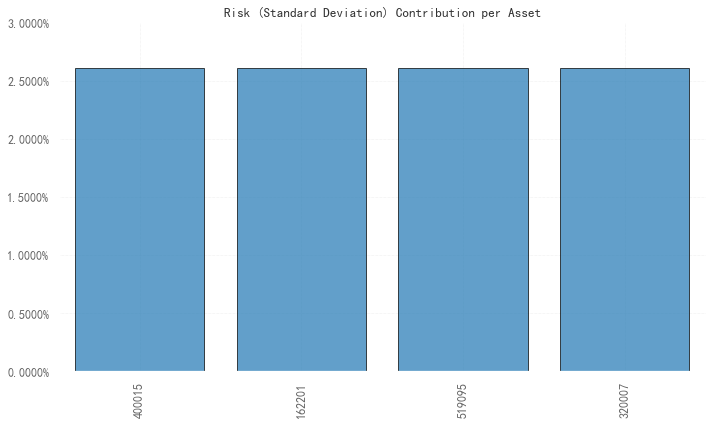

In [13]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w_rp,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

In [14]:
w_mr = port.optimization(model='Classic', rm='MV', obj='MinRisk', kelly=False, rf=0, l=2, hist=True)
display(w_mr.T)

,400015,162201,519095,320007
weights,0.436697,2.993170e-08,0.563303,1.564849e-07


In [19]:
w_mr.columns = ['w_mr']

In [25]:
pd.merge(w_mr,w_rp,left_on=w_mr.index,right_on = w_rp.index).set_index()

,key_0,w_mr,weights
0,400015,4.366972e-01,0.284259
1,162201,2.993170e-08,0.207013
2,519095,5.633026e-01,0.280243
3,320007,1.564849e-07,0.228485
